In [1]:
#!pip install wordcloud

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from surprise import accuracy
from surprise.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
md = pd.read_csv("data/movies_metadata.csv")
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
md.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

# Cleaning the Dataset

In [4]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

md['production_companies']= md['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

md['production_countries'] = md['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

md['spoken_languages'] = md['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


In [5]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [6]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].values:        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [7]:
genre_labels = set()
for s in md['genres'].values:
    genre_labels = genre_labels.union(set(s))

In [8]:
keyword_occurences, dum = count_word(md, 'genres', genre_labels)
keyword_occurences[:10]

[['Drama', 20265],
 ['Comedy', 13182],
 ['Thriller', 7624],
 ['Romance', 6735],
 ['Action', 6596],
 ['Horror', 4673],
 ['Crime', 4307],
 ['Documentary', 3932],
 ['Adventure', 3496],
 ['Science Fiction', 3049]]

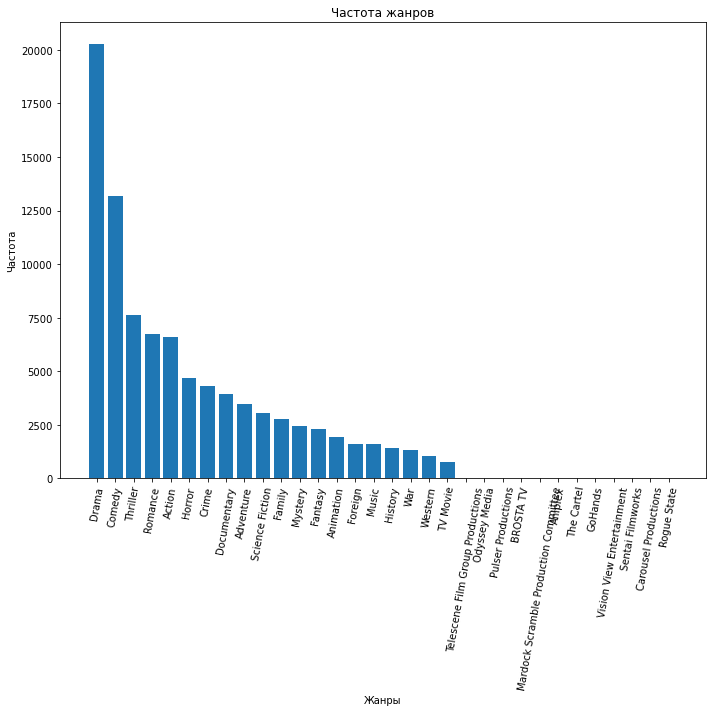

In [9]:
genres = [item[0] for item in keyword_occurences]
frequencies = [item[1] for item in keyword_occurences]

plt.figure(figsize=(10, 10))  
plt.bar(genres, frequencies)  

plt.xlabel('Жанры')
plt.ylabel('Частота')
plt.title('Частота жанров')

plt.xticks(rotation=80)

plt.tight_layout()  
plt.show()  

# Топ 250 фильмов

Формула для фильмов, которые входят в Топ чарт: 

$$WR = \left( \frac{v}{v+m} \right) \cdot R + \left( \frac{m}{v+m} \right) \cdot C
$$


где, <br>
R = средняя оценка фильма (среднее значение) = (рейтинг) <br>v = количество голосов за фильм = (голосов) <br>m = минимальное количество голосов, необходимое для попадания в Топ-250 <br> C = среднее количество голосов по всему отчету 

In [10]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
print('Среднее значение средних показателей голосования:',C)
print('Минимальное количество голосов для рассмотрения фильма:',m)

Среднее значение средних показателей голосования: 5.244896612406511
Минимальное количество голосов для рассмотрения фильма: 434.0


In [12]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]"
17,Four Rooms,1995,539,6,9.026586,"[Crime, Comedy]"
18,Ace Ventura: When Nature Calls,1995,1128,6,8.205448,"[Crime, Comedy, Adventure]"
31,Twelve Monkeys,1995,2470,7,12.297305,"[Science Fiction, Thriller, Mystery]"
33,Babe,1995,756,6,14.404764,"[Fantasy, Drama, Comedy, Family]"
38,Clueless,1995,828,6,9.882383,"[Comedy, Drama, Romance]"


In [13]:
def wr(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
qualified['wr'] = qualified.apply(wr, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [15]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


# Content Based Recommender

In [16]:
links = pd.read_csv("data/links.csv")
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [17]:
links

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45838    439050
45839    111109
45840     67758
45841    227506
45842    461257
Name: tmdbId, Length: 45624, dtype: int32

In [18]:
rows_to_check = md.loc[[19730, 29503, 35587]]
print(rows_to_check['id'])
md = md.drop([19730, 29503, 35587])

19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object


In [19]:
md['id'] = md['id'].astype('int')

In [20]:
smd = md[md['id'].isin(links)]
smd.shape

(45463, 25)

In [21]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [22]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [23]:
tfidf_matrix.shape

(45463, 1104495)

In [24]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00511811, 0.        , ..., 0.        , 0.00236862,
       0.        ])

In [25]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [26]:
def content_based_recomandation(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [27]:
movie_title = "Star Wars"
print("Описание фильма", movie_title, ":")
print(smd[smd['title']==movie_title]['overview'].values)

Описание фильма Star Wars :
['Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire.']


In [28]:
content_based_recomandation(movie_title)

30432                   The Star Wars Holiday Special
1154                          The Empire Strikes Back
1167                               Return of the Jedi
26554                    Star Wars: The Force Awakens
22117                              The Galaxy Invader
22938                              Threads of Destiny
34151      Samson and the Seven Miracles of the World
26239                           Princess and the Pony
10069    Star Wars: Episode III - Revenge of the Sith
11825                                 Shrek the Third
27239                                Pleasure or Pain
45178                          A Wolf from Vesyegonsk
8850                                  The Ice Pirates
6659                                Where Eagles Dare
3511                  On Her Majesty's Secret Service
15372                             Shrek Forever After
7149                              The Thief of Bagdad
20811                                          Erased
7717                        

In [29]:
movie_title = "Shrek 2"
print("Описание фильма", movie_title, ":")
print(smd[smd['title']==movie_title]['overview'].values)

Описание фильма Shrek 2 :
["Shrek, Fiona and Donkey set off to Far, Far Away to meet Fiona's mother and father. But not everyone is happy. Shrek and the King find it hard to get along, and there's tension in the marriage. The fairy godmother discovers that Shrek has married Fiona instead of her Son Prince Charming and sets about destroying their marriage."]


In [30]:
content_based_recomandation(movie_title)

11825                  Shrek the Third
15372              Shrek Forever After
31247                            Fiona
4178                             Shrek
45178           A Wolf from Vesyegonsk
11867                        L'iceberg
13152                  Shrek the Halls
43769             Moonlight in Vermont
16099                 Scared Shrekless
40916                The Blood Oranges
15230                      Donkey Skin
42078           A Prince for Christmas
310           The Secret of Roan Inish
22117               The Galaxy Invader
20309                           Choose
23506                       Cinderella
30432    The Star Wars Holiday Special
27239                 Pleasure or Pain
43014                    Lost in Paris
45047                            Rumba
Name: title, dtype: object

# Metadata Recommender

In [31]:
credits = pd.read_csv('data/credits.csv')
keywords = pd.read_csv('data/keywords.csv')

In [32]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [33]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [42]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [43]:
smd = md[md['id'].isin(links)]
smd.shape

(46628, 28)

In [44]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [45]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [46]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [47]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [48]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [49]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

In [54]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [55]:
s = s.value_counts()
s[:10]

woman director      3128
independent film    1942
murder              1314
based on novel       841
musical              734
sex                  685
violence             651
biography            641
nudity               636
revenge              626
Name: keyword, dtype: int64

In [56]:
s = s[s > 1]

In [57]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

'sport'

In [58]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [59]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [60]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [61]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting, oldmen]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting oldmen walt...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,4.0,1.0,NaT,"[leilahatami, kouroshtahami, elhamkorda]","[{'credit_id': '5894a97d925141426c00818c', 'de...",[tragiclov],3,9,"[hamidnematollah, hamidnematollah, hamidnemato...",tragiclov leilahatami kouroshtahami elhamkorda...
46624,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,9.0,3.0,2011,"[angelaquino, perrydizon, hazelorencio]","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...","[artist, play, pinoy]",11,6,"[lavdiaz, lavdiaz, lavdiaz]",artist play pinoy angelaquino perrydizon hazel...
46625,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,3.8,6.0,2003,"[erikaeleniak, adambaldwin, juliedupage]","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",[],15,5,"[markl.lester, markl.lester, markl.lester]",erikaeleniak adambaldwin juliedupage markl.les...
46626,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,0.0,1917,"[iwanmosschuchin, nathalielissenko, pavelpavlov]","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",[],5,2,"[yakovprotazanov, yakovprotazanov, yakovprotaz...",iwanmosschuchin nathalielissenko pavelpavlov y...


In [62]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [63]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [64]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [65]:
def metadata_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'genres', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.50)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(wr, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [66]:
metadata_recommender("Pulp Fiction")

,title,vote_count,vote_average,genres,year,wr
1078,Reservoir Dogs,3821,8,"[Crime, Thriller]",1992,7.718986
20254,Django Unchained,10297,7,"[Drama, Western]",2012,6.929017
13756,Inglourious Basterds,6598,7,"[Drama, Action, Thriller, War]",2009,6.891679
6794,Kill Bill: Vol. 1,5091,7,"[Action, Crime]",2003,6.862133
28345,The Hateful Eight,4405,7,"[Crime, Drama, Mystery, Western]",2015,6.842588
7340,Kill Bill: Vol. 2,4061,7,"[Action, Crime, Thriller]",2004,6.830542
1667,Jackie Brown,1580,7,"[Comedy, Crime, Romance]",1997,6.621790
11978,Death Proof,1359,6,"[Action, Thriller]",2007,5.817225
6194,Basic,290,6,"[Action, Drama, Mystery, Thriller, Crime]",2003,5.547355
5207,Changing Lanes,306,5,"[Action, Adventure, Crime, Thriller]",2002,5.143629


# Collaborative Filtering

In [67]:
reader = Reader()
ratings = pd.read_csv('data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [68]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.90259597, 0.90083499, 0.88882146, 0.89366508, 0.89914001]),
 'test_mae': array([0.69773782, 0.69466987, 0.68453312, 0.68640235, 0.69179594]),
 'fit_time': (4.720388650894165,
  4.693133354187012,
  4.714715480804443,
  4.6999289989471436,
  4.741691589355469),
 'test_time': (0.18981194496154785,
  0.1587202548980713,
  0.1451091766357422,
  0.13835787773132324,
  0.15751314163208008)}

In [69]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [70]:
user_rating=pd.merge(ratings,md,left_on='movieId',right_on='id',how='inner')
user_ratings_final=user_rating[['userId', 'movieId', 'rating','original_title', 'genres']]
user_ratings=user_ratings_final.sort_values(by='userId')
user_ratings.head()

,userId,movieId,rating,original_title,genres
0,1,1371,2.5,Rocky III,[Drama]
93,1,2105,4.0,American Pie,"[Comedy, Romance]"
140,1,2193,2.0,My Tutor,"[Comedy, Drama, Romance]"
47,1,1405,1.0,Greed,"[Drama, History]"
182,1,2294,2.0,Jay and Silent Bob Strike Back,[Comedy]


In [85]:
user_id = 89
user_ratings[user_ratings['userId'] == user_id]

,userId,movieId,rating,original_title,genres
20457,89,4896,5.0,Muxmäuschenstill,"[Comedy, Drama]"
14726,89,344,5.0,Bang Boom Bang - Ein todsicheres Ding,"[Crime, Action, Comedy]"
20333,89,4886,4.0,And Then There Were None,"[Crime, Drama, Mystery]"
11022,89,1265,4.5,Bridge to Terabithia,"[Adventure, Drama, Family]"
32167,89,45722,5.0,No mires para abajo,"[Drama, Romance]"
16018,89,3114,4.5,The Searchers,[Western]
5584,89,590,5.0,The Hours,[Drama]
7536,89,2028,5.0,Say Anything...,"[Comedy, Drama, Romance]"
7975,89,2959,5.0,License to Wed,[Comedy]
2255,89,296,5.0,Terminator 3: Rise of the Machines,"[Action, Thriller, Science Fiction]"


In [90]:
movie=md['original_title']=='The Green Mile'
md[movie][['original_title','id']]

,original_title,id
3057,The Green Mile,497


In [91]:
movie_id = md[movie][['id']].values[0][0]

In [92]:
svd.predict(user_id, movie_id)

Prediction(uid=89, iid=497, r_ui=None, est=4.899781695144282, details={'was_impossible': False})

# A Combination Recommender

In [75]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [76]:
id_map = pd.read_csv('data/links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
Subdue,176269,439050.0
Century of Birthing,176271,111109.0
Betrayal,176273,67758.0


In [77]:
indices_map = id_map.set_index('id')
indices_map

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
439050.0,176269
111109.0,176271
67758.0,176273


In [78]:
def recommend_movie(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [79]:
recommend_movie(user_id, "Arlington Road")

,title,vote_count,vote_average,year,id,est
12994,Henry Poole Is Here,64.0,5.8,2008,13107,4.664926
2856,Mike's Murder,4.0,5.5,1984,31043,4.611455
4573,Sea of Love,144.0,6.7,1989,12150,4.601892
3854,The Contender,61.0,6.7,2000,6521,4.598595
4435,Masquerade,14.0,5.2,1988,41963,4.585682
3636,Cutter's Way,32.0,6.3,1981,31593,4.512054
1545,Conspiracy Theory,440.0,6.5,1997,8834,4.489236
1324,Blood and Wine,34.0,5.5,1996,31640,4.383758
17331,Across the Hall,30.0,6.3,2009,21469,4.382301
30288,Tiger Bay,11.0,7.8,1959,43112,4.382301


In [97]:
trainset, testset = train_test_split(data, test_size=0.2)

svd.fit(trainset)

predictions = svd.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.9024
MAE:  0.6929
RMSE: 0.9024203302292375
MAE: 0.6928650671667198
